In [1]:
import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf



In [10]:
# You only need to run this once, this is default commented out for this reason
# Creates cleaned_df.pkl in the data folder
#%run ./data/cleaning_script.py


In [2]:
df = pd.read_pickle('data/cleaned_df.pkl')

In [3]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'yr_sold',
       'was_renovated', 'effective_age', 'log_price', 'space_needle_dist',
       'space_needle_bearing'],
      dtype='object')

In [4]:

df.iat[8748, 3] = 4
df.iat[15856, 3] = 3
df.sort_values('bedrooms', ascending=False)
#df['bedrooms_per_sf'] = df.bedrooms/df.sqft_living
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'yr_sold',
       'was_renovated', 'effective_age', 'log_price', 'space_needle_dist',
       'space_needle_bearing'],
      dtype='object')

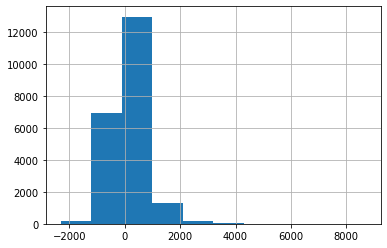

In [31]:
#np.log(df.sqft_living).hist()
df['log_sqft_living'] = np.log(df.sqft_living)
df['diff_lsf_neighbors'] = df.sqft_living - df.sqft_living15
df.diff_lsf_neighbors.hist()

In [6]:
df = df[df.sqft_living < 8000]

In [7]:
df[df.sqft_living >=8000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,yr_sold,was_renovated,effective_age,log_price,space_needle_dist,space_needle_bearing


In [54]:
mean_log_sqft_living = df.log_sqft_living.mean()
sigma_log_sqft_living = df.log_sqft_living.std()
df['log_normal_sf_living'] = (df.log_sqft_living - mean_log_sqft_living) / sigma_log_sqft_living

In [55]:
mean_sqft_living = df.sqft_living.mean()
sigma_sqft_living = df.sqft_living.std()
df['normal_sf_living'] = (df.sqft_living - mean_sqft_living) / sigma_sqft_living

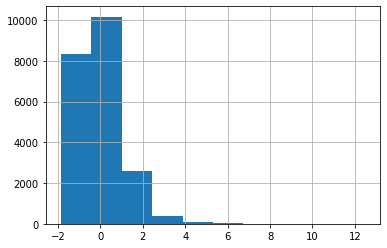

In [52]:
df.normal_sf_living.hist()

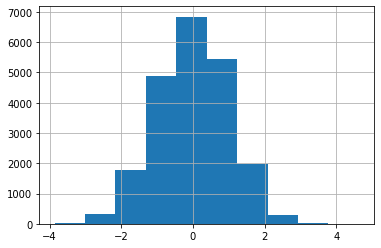

In [56]:
df.log_normal_sf_living.hist()

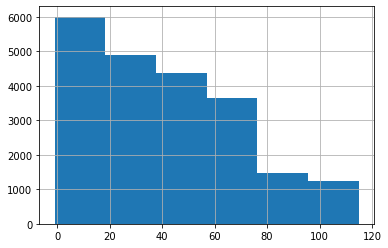

In [73]:
df.effective_age.hist(bins=6)

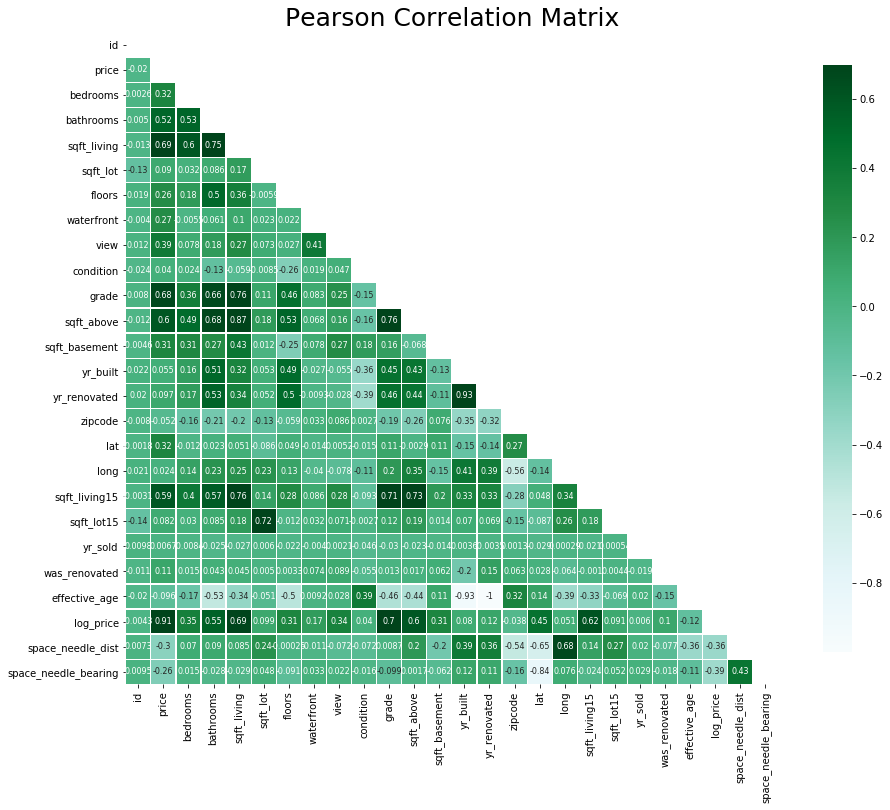

In [8]:
features = list(df.columns)

mask = np.zeros_like(df[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});


In [9]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=16)


In [10]:
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_lat_long_logprice = train_set[['lat', 'long', 'log_price']]

train_scaled = scaler.fit_transform(train_lat_long_logprice)
pd.DataFrame(train_scaled).describe()



,0,1,2
count,1.726900e+04,1.726900e+04,1.726900e+04
mean,2.987612e-14,5.531320e-15,-6.796604e-16
std,1.000029e+00,1.000029e+00,1.000029e+00
min,-2.912024e+00,-2.166252e+00,-3.386140e+00
25%,-6.526990e-01,-8.118653e-01,-7.027140e-01
50%,8.865324e-02,-1.169447e-01,-5.462432e-02
75%,8.501588e-01,6.347042e-01,6.253025e-01
max,1.562721e+00,6.371345e+00,4.633564e+00


Text(0, 0.5, 'Inertia')

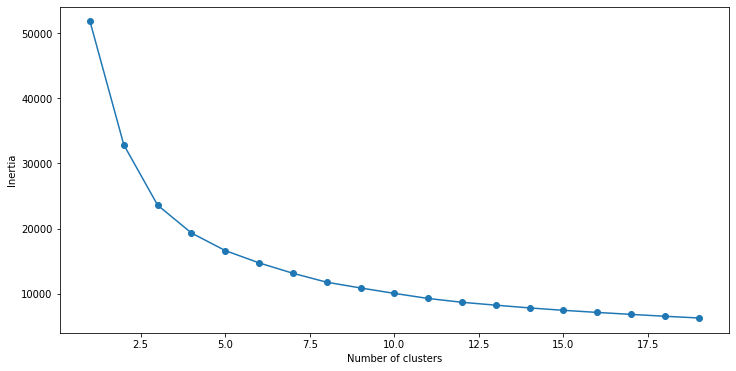

In [11]:
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(train_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [12]:
kmeans = KMeans(n_jobs = -1, n_clusters = 5, init='k-means++', random_state=16)
kmeans.fit(train_scaled)
train_pred = kmeans.predict(train_scaled)


train_frame = pd.DataFrame(train_scaled)
train_frame['cluster'] = train_pred
train_frame['cluster'].value_counts()

train_centers = kmeans.cluster_centers_
train_centers_frame = pd.DataFrame(scaler.inverse_transform(train_centers), columns=['klat', 'klong', 'log'])[['klat','klong']]
train_centers_frame.sort_values(by='klat', inplace=True)
train_centers_frame.reset_index(drop=True, inplace=True)
train_centers_frame


,klat,klong
0,47.380987,-122.123506
1,47.434709,-122.316159
2,47.608892,-122.028312
3,47.617300,-122.248814
4,47.676715,-122.312718


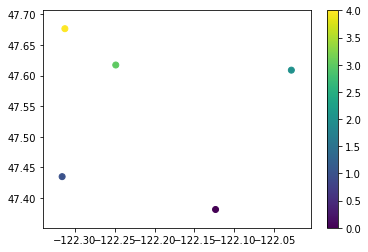

In [13]:
plt.scatter(train_centers_frame.klong, train_centers_frame.klat, c = train_centers_frame.index,
           label = train_centers_frame.index)
plt.colorbar()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


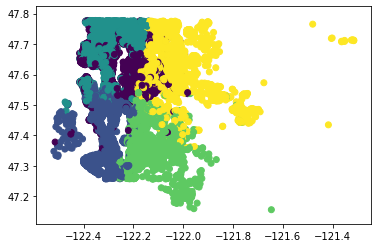

In [14]:
train_set['cluster'] = train_pred
plt.scatter(train_set.long, train_set.lat, c=train_set.cluster)

In [15]:
def distance_from(flat, flong, lat, long):
    """return 'as the crow flies' distance in miles from the 
    space needle, given latitude and longitude coordinates of a location"""
    # Convert lat/longitudes to radians
    def to_radians(latlong):
        return latlong / 57.29577951
    # lat/long of input
    loc_lat = to_radians(lat)
    loc_long = to_radians(long)
    c_lat = to_radians(flat)
    c_long = to_radians(flong)
    # distance in miles
    d = 3963.0 * np.arccos((np.sin(c_lat) * np.sin(loc_lat))\
                           + np.cos(c_lat) * np.cos(loc_lat)\
                           * np.cos(loc_long - c_long))
    return d

    
# Create a Function for computing the bearing relative from space needle
# of a given lat/long point
def bearing_from(flat, flong, lat, long):
    """return bearing theta in radians for given location's
    bearing relative to the space needle. Takes latitude and longitude
    of the location."""
    delta_fi = np.log(np.tan(flat / 2 + np.pi/4) / np.tan(lat / 2 + np.pi/4))
    delta_lon = abs(flong - long)
    bearing = np.arctan2(delta_lon, delta_fi)
    return bearing

In [191]:
drop_cols = train_set.columns[-9:]
train_set.drop(columns=drop_cols, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [190]:
train_set.columns[-9:]

Index(['cluster', 'dist_c0', 'bear_c0', 'dist_c1', 'bear_c1', 'dist_c2',
       'bear_c2', 'dist_c3', 'bear_c3'],
      dtype='object')

In [16]:
train_set.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,yr_sold,was_renovated,effective_age,log_price,space_needle_dist,space_needle_bearing,cluster
12702,5014000085,2014-06-23,425000.0,2,1.0,880,6413,1.0,0.0,0.0,...,-122.395,1360,6413,2014,False,64.0,12.959844,3.916347,2.433389,2
10450,6056100295,2014-05-30,330000.0,2,2.5,1240,1546,2.0,0.0,0.0,...,-122.298,1520,2468,2014,False,7.0,12.706848,4.617857,2.465859,1
10209,8947250060,2015-03-26,292500.0,4,2.5,1610,4568,2.0,NaN,0.0,...,-122.289,1834,4604,2015,False,9.0,12.586220,19.940631,2.946766,1
7095,9297300480,2014-12-12,765000.0,4,3.5,2760,4000,2.0,0.0,2.0,...,-122.374,1690,4000,2014,True,0.0,13.547631,3.763555,2.739803,0
19486,8151600900,2014-11-12,445000.0,5,3.0,2420,11250,2.0,0.0,0.0,...,-122.362,1510,9950,2014,False,1.0,13.005830,7.790081,3.039728,1


In [17]:
for i in train_centers_frame.index:
    dist_col_name = f'dist_c{i}'
    bear_col_name = f'bear_c{i}'
    train_set[dist_col_name] = distance_from(train_centers_frame.loc[i, 'klat'], train_centers_frame.loc[i, 'klong'], train_set.lat, train_set.long)
    train_set[bear_col_name] = bearing_from(train_centers_frame.loc[i, 'klat'], train_centers_frame.loc[i, 'klong'], train_set.lat, train_set.long)

# train_set['dist_c0'] = distance_from(train_centers_frame['klat'][0], train_centers_frame['klong'][0], train_set.lat, train_set.long)
# train_set['bear_c0'] = bearing_from(train_centers_frame['klat'][0], train_centers_frame['klong'][0], train_set.lat, train_set.long)
# train_set['dist_c1'] = distance_from(train_centers_frame['klat'][1], train_centers_frame['klong'][1], train_set.lat, train_set.long)
# train_set['bear_c1'] = bearing_from(train_centers_frame['klat'][1], train_centers_frame['klong'][1], train_set.lat, train_set.long)
# train_set['dist_c2'] = distance_from(train_centers_frame['klat'][2], train_centers_frame['klong'][2], train_set.lat, train_set.long)
# train_set['bear_c2'] = bearing_from(train_centers_frame['klat'][2], train_centers_frame['klong'][2], train_set.lat, train_set.long)
# # train_set['dist_c3'] = distance_from(train_centers_frame['klat'][3], train_centers_frame['klong'][3], train_set.lat, train_set.long)
# # train_set['bear_c3'] = bearing_from(train_centers_frame['klat'][3], train_centers_frame['klong'][3], train_set.lat, train_set.long)
# # train_set['dist_c4'] = distance_from(train_centers_frame['klat'][4], train_centers_frame['klong'][4], train_set.lat, train_set.long)
# # train_set['bear_c4'] = bearing_from(train_centers_frame['klat'][4], train_centers_frame['klong'][4], train_set.lat, train_set.long)
# train_set.drop(columns=['dist_c3', 'dist_c4', 'bear_c3', 'bear_c4'], inplace=True)
train_set


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,dist_c0,bear_c0,dist_c1,bear_c1,dist_c2,bear_c2,dist_c3,bear_c3,dist_c4,bear_c4
12702,5014000085,2014-06-23,425000.0,2,1.00,880,6413,1.0,0.0,0.0,...,18.370507,0.923959,10.250123,0.486493,17.284414,1.679993,7.475527,1.898669,8.134797,2.533985
10450,6056100295,2014-05-30,330000.0,2,2.50,1240,1546,2.0,0.0,0.0,...,15.024825,0.731472,8.941597,0.130425,12.969029,1.757099,4.377577,2.457824,7.867662,3.027959
10209,8947250060,2015-03-26,292500.0,4,2.50,1610,4568,2.0,NaN,0.0,...,8.378643,1.848510,7.006088,2.884141,22.520633,2.413500,19.609211,3.009279,23.654572,3.077672
7095,9297300480,2014-12-12,765000.0,4,3.50,2760,4000,2.0,0.0,2.0,...,17.484806,0.896358,9.653891,0.381230,16.364125,1.700156,6.737854,1.981360,7.998711,2.679681
19486,8151600900,2014-11-12,445000.0,5,3.00,2420,11250,2.0,0.0,0.0,...,14.208614,1.058391,5.516572,0.530285,17.061673,1.892150,9.211477,2.387923,11.880257,2.886793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17738,126059019,2015-03-16,799000.0,4,2.50,3170,94855,1.0,0.0,0.0,...,26.552759,0.026756,24.737551,0.499714,11.466174,0.425445,12.027477,0.663070,11.151319,1.082719
581,7511800070,2014-08-21,264000.0,3,1.50,1820,10608,1.0,0.0,0.0,...,9.085111,1.815885,6.802579,3.041951,22.874909,2.379400,19.598451,2.953482,23.526942,3.123390
2171,1796381070,2014-06-25,270000.0,3,2.50,1670,8364,1.0,0.0,0.0,...,2.027717,1.874369,11.780749,1.857101,16.795632,2.928700,18.822413,2.588798,23.814442,2.543578
15607,2019200480,2014-08-13,220000.0,3,2.25,1470,7518,1.0,0.0,0.0,...,11.170254,2.131464,11.245074,3.045012,26.512514,2.489794,23.968779,3.002484,27.964800,3.112310


In [33]:
col_combos = [f'+ dist_c{i}*bear_c{i} ' if i !=2 else '+ bear_c2 + dist_c2:bear_c2' for i in train_centers_frame.index]
formula = 'log_price ~ sqft_living ' + ''.join(col_combos)

model = smf.ols(formula=formula, data=train_set)
fitted_model = model.fit()

fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     4956.
Date:                Wed, 08 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:39:36   Log-Likelihood:                 1002.9
No. Observations:               17269   AIC:                            -1974.
Df Residuals:                   17253   BIC:                            -1850.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          12.8329      0.048    267.175      0.000      12.739      12.927
sqft_living         0.0004   2.08e-06    175.167      0.000       0.000       0.000
dist_c0             0.0079      0.002      3.856      0.000       0.004       0.012
bear_c0             0.1112      0.010     11.517      0.000       0.092       0.130
dist_c0:bear_c0     0.0121      0.001     11.541      0.000       0.010       0.014
dist_c1            -0.0278      0.002    -11.779      0.000      -0.032      -0.023
bear_c1             0.2886      0.009     32.204      0.000       0.271       0.306
dist_c1:bear_c1     0.0323      0.001     23.966      0.000       0.030       0.035
bear_c2             0.0194      0.008      2.516      0.012       0.004       0.035
dist_c2:bear_c2     0.0107      0.001     21.376      0.000       0.010       0.012
dist_c3            -0.1142      0.004    -27.375      0.000      -0.122      -0.106
bear_c3            -0.1522      0.011    -14.460      0.000      -0.173      -0.132
dist_c3:bear_c3     0.0195      0.002     10.335      0.000       0.016       0.023
dist_c4             0.1006      0.004     22.649      0.000       0.092       0.109
bear_c4             0.1360      0.007     19.531      0.000       0.122       0.150
dist_c4:bear_c4    -0.0637      0.002    -35.377      0.000      -0.067      -0.060
==============================================================================
Omnibus:                     1082.134   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4644.063
Skew:                           0.137   Prob(JB):                         0.00
Kurtosis:                       5.526   Cond. No.                     6.34e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
# train_set.columns[-10:]
cols = list(train_set.columns[-10:])
cols.append('sqft_living')
cols

['dist_c0',
 'bear_c0',
 'dist_c1',
 'bear_c1',
 'dist_c2',
 'bear_c2',
 'dist_c3',
 'bear_c3',
 'dist_c4',
 'bear_c4',
 'sqft_living']

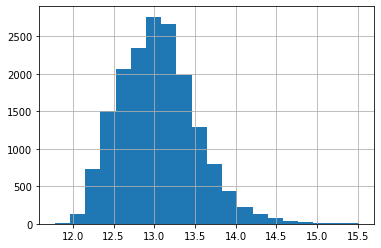

In [28]:
model_predictions.hist(bins=20)

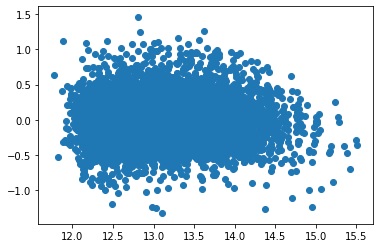

In [23]:
x_preds = train_set[cols]
y_actual = train_set['log_price']
model_predictions = fitted_model.predict(x_preds)
residuals = y_actual - model_predictions
plt.scatter(model_predictions, residuals)


In [287]:
outliers = list(model_predictions[model_predictions >15.5].index)
outliers

[7245, 4407, 1446, 1162, 12764, 9245, 8085, 7028]

In [283]:

living_8000 = train_set.sqft_living >= 8000


In [286]:
len(train_set) - len(train_set.loc[~ living_8000])

9

In [273]:
train_set.loc[train_set.index.isin(outliers), list(train_set.columns[2:-20])]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,long,sqft_living15,sqft_lot15,yr_sold,was_renovated,effective_age,log_price,space_needle_dist,space_needle_bearing,cluster
7245,7700000.0,6,8.00,12050,27600,2.5,0.0,3.0,4,13,...,-122.323,3940,8800,2014,True,27.0,15.856731,1.384537,1.187518,3
4407,5570000.0,5,5.75,9200,35069,2.0,0.0,0.0,3,13,...,-122.233,3560,24345,2014,False,13.0,15.532906,5.452683,1.488643,3
1446,5350000.0,5,5.00,8000,23985,2.0,0.0,4.0,3,12,...,-122.220,4600,21750,2015,False,6.0,15.492607,6.030891,1.547033,3
1162,5110000.0,5,5.25,8010,45517,2.0,1.0,4.0,3,12,...,-122.211,3430,26788,2014,False,15.0,15.446710,7.525897,1.131737,3
12764,2280000.0,7,8.00,13540,307752,3.0,0.0,4.0,3,12,...,-121.986,4850,217800,2014,False,15.0,14.639686,17.239234,1.422780,3
9245,6890000.0,6,7.75,9890,31374,2.0,0.0,4.0,3,13,...,-122.240,4540,42730,2014,False,13.0,15.745582,5.141971,1.466826,3
8085,4670000.0,5,6.75,9640,13068,1.0,1.0,4.0,3,12,...,-122.210,3270,10454,2014,True,5.0,15.356670,7.843395,2.042487,3
7028,3800000.0,5,5.50,7050,42840,1.0,0.0,2.0,4,13,...,-122.220,5070,20570,2014,False,36.0,15.150512,6.030301,1.549674,3


In [28]:
test_set['dist_c0'] = distance_from(train_centers_frame['klat'][0], train_centers_frame['klong'][0], test_set.lat, test_set.long)
test_set['bear_c0'] = bearing_from(train_centers_frame['klat'][0], train_centers_frame['klong'][0], test_set.lat, test_set.long)
test_set['dist_c1'] = distance_from(train_centers_frame['klat'][1], train_centers_frame['klong'][1], test_set.lat, test_set.long)
test_set['bear_c1'] = bearing_from(train_centers_frame['klat'][1], train_centers_frame['klong'][1], test_set.lat, test_set.long)
test_set['dist_c2'] = distance_from(train_centers_frame['klat'][2], train_centers_frame['klong'][2], test_set.lat, test_set.long)
test_set['bear_c2'] = bearing_from(train_centers_frame['klat'][2], train_centers_frame['klong'][2], test_set.lat, test_set.long)
test_set['dist_c3'] = distance_from(train_centers_frame['klat'][3], train_centers_frame['klong'][3], test_set.lat, test_set.long)
test_set['bear_c3'] = bearing_from(train_centers_frame['klat'][3], train_centers_frame['klong'][3], test_set.lat, test_set.long)
test_set['dist_c4'] = distance_from(train_centers_frame['klat'][4], train_centers_frame['klong'][4], test_set.lat, test_set.long)
test_set['bear_c4'] = bearing_from(train_centers_frame['klat'][4], train_centers_frame['klong'][4], test_set.lat, test_set.long)



test_x_preds = test_set[['sqft_living', 'dist_c0', 'bear_c0', 'bear_c1', 'dist_c2', 'bear_c2', 'dist_c3', 'bear_c3', 'dist_c4', 'bear_c4']]

test_preds = fitted_model.predict(test_x_preds)

log_price_mean = test_set.log_price.mean()
TSS = ((test_set.log_price - (log_price_mean))**2).sum()
RSS = ((test_set.log_price - test_preds)**2).sum()

R_sq = 1 - (RSS / TSS)

R_sq

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

0.809901189011705

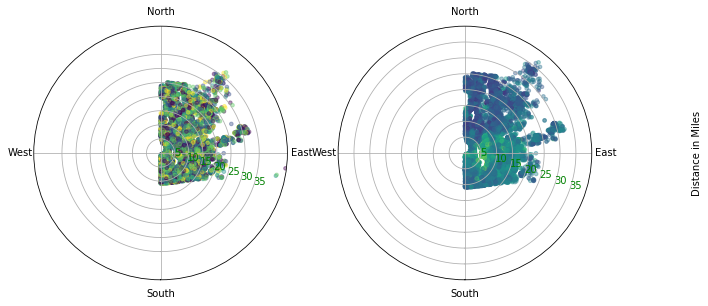

In [24]:
# df['cluster'] = pred

# df['log10_price'] = np.log10(df.price)
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)
# plt.style.use('seaborn-white')
r = train_set.space_needle_dist
theta = train_set.space_needle_bearing
area = train_set.log_price
colors = train_set.cluster


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121, projection='polar')
c = ax.scatter(theta, r, c=colors, s=area, alpha=0.4 )
ax.set_theta_zero_location('W', offset=90)
ax.set_xticks(np.array([0, 90, 180, 270])*np.pi/180)
ax.set_xticklabels(['South','East', 'North', 'West'])
#ax.set_rticks([0,5,10,15,20,25,30,35,40,45,50])
ax.set_rmax(45)
#ax.set_tickparams(axis='y', colors='red')
#ax.r_label_position('right')
ax.set_rgrids([5,10,15,20,25,30,35], angle=70, color='green')
ax.set_ylabel('Distance in Miles', labelpad=100)
ax.yaxis.set_label_position('right')
#ax.set_title('Distance and Direction from Space Needle, colored by Log 10 Sale Price')




ax1 = fig.add_subplot(122, projection='polar')
c2 = ax1.scatter(theta, r, c=area, s=area, alpha=0.4)
ax1.set_theta_zero_location('W', offset=90)
ax1.set_xticks(np.array([0, 90, 180, 270])*np.pi/180)
ax1.set_xticklabels(['South','East', 'North', 'West'])
#ax.set_rticks([0,5,10,15,20,25,30,35,40,45,50])
ax1.set_rmax(40)
#ax.set_tickparams(axis='y', colors='red')
#ax.r_label_position('right')
ax1.set_rgrids([5,10,15,20,25,30,35], angle=70, color='green')
ax1.set_ylabel('Distance in Miles', labelpad=100)
ax1.yaxis.set_label_position('right')
#ax1.set_title('Distance and Direction from Space Needle, colored by Log 10 Sale Price')

# ax3 = fig.add_subplot(133, projection='polar')
# c3 = ax3.scatter(theta, r, c=colors2, s=area, alpha=0.4)
# ax3.set_theta_zero_location('W', offset=90)
# ax3.set_xticks(np.array([0, 90, 180, 270])*np.pi/180)
# ax3.set_xticklabels(['South','East', 'North', 'West'])
# #ax.set_rticks([0,5,10,15,20,25,30,35,40,45,50])
# ax3.set_rmax(40)
# #ax.set_tickparams(axis='y', colors='red')
# #ax.r_label_position('right')
# ax3.set_rgrids([5,10,15,20,25,30,35], angle=70, color='green')
# ax3.set_ylabel('Distance in Miles', labelpad=100)
# ax3.yaxis.set_label_position('right')
# #ax.set_title('Distance and Direction from Space Needle, colored by Log 10 Sale Price')



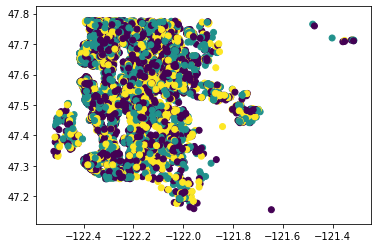

In [51]:
plt.scatter(train_set.long, train_set.lat, c=train_set.cluster)

In [104]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


lat_long_logprice = df[['lat', 'long', 'log_price']]
data_scaled = scaler.fit_transform(lat_long_logprice)


db = DBSCAN(eps=0.3, min_samples=10).fit(data_scaled)

labels = db.labels_

df['cluster_db'] = labels

df.head()




,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,space_needle_bearing,bedrooms_per_sf,log_sqft_living,diff_lsf_neighbors,normal_sf_living,log_normal_sf_living,split_level,cluster,log10_price,cluster_db
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,2.489966,0.002542,7.073270,-160,-0.980629,-1.125556,0.0,3,5.346157,0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,0.251870,0.001167,7.851661,880,0.533357,0.709446,0.0,0,5.730782,0
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,0.699198,0.002597,6.646391,-1950,-1.427201,-2.131893,0.0,0,5.255273,-1
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,2.765356,0.002041,7.580700,600,-0.131054,0.070674,0.0,0,5.781037,0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1.584611,0.001786,7.426549,-120,-0.436030,-0.292725,0.0,4,5.707570,0


In [108]:
df.cluster_db.value_counts()

 0    20862
-1      465
 1      198
 4       35
 3       21
 2       11
 5        5
Name: cluster_db, dtype: int64

In [149]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'yr_sold',
       'was_renovated', 'effective_age', 'log_price', 'space_needle_dist',
       'space_needle_bearing', 'bedrooms_per_sf', 'log_sqft_living',
       'diff_lsf_neighbors', 'normal_sf_living', 'log_normal_sf_living',
       'cluster', 'log10_price', 'dist_c0', 'bear_c0', 'dist_c1', 'bear_c1',
       'dist_c2', 'bear_c2', 'dist_c3', 'bear_c3', 'dist_c4', 'bear_c4'],
      dtype='object')